In [4]:
# Part 1: Setup and Data Exploration
# Step 1.1: Import Libraries

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Scikit-learn imports
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
 accuracy_score,
 classification_report,
 confusion_matrix,
 ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")





Libraries imported successfully!


In [5]:
# Step 1.2: Load Dataset
# Define categories (subset for speed)
categories = [
 'alt.atheism', # Religion/philosophy discussions
 'comp.graphics', # Computer graphics
 'sci.space', # Space science and astronomy
 'talk.religion.misc' # General religion discussions
]
# Load training data
train_data = fetch_20newsgroups(
 subset='train',
 categories=categories,
 shuffle=True,
 random_state=42,
 remove=('headers', 'footers', 'quotes') # Remove metadata to prevent leakage
)
# Load test data
test_data = fetch_20newsgroups(
 subset='test',
 categories=categories,
 shuffle=True,
 random_state=42,
 remove=('headers', 'footers', 'quotes')
)
print(f"Training samples: {len(train_data.data)}")
print(f"Test samples: {len(test_data.data)}")
print(f"Categories: {train_data.target_names}")




Training samples: 2034
Test samples: 1353
Categories: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [6]:
# Step 1.3: Explore the Data
# Display a sample document
print("\n=== Sample Document ===")
print(f"Category: {train_data.target_names[train_data.target[0]]}")
print(f"Text (first 500 chars):\n{train_data.data[0][:500]}...")
# Check class distribution
print("\n=== Class Distribution (Training) ===")
unique, counts = np.unique(train_data.target, return_counts=True)
for label, count in zip(unique, counts):
 print(f"{train_data.target_names[label]:<25} {count:>4} samples")
# Calculate document length statistics
doc_lengths = [len(doc.split()) for doc in train_data.data]
print(f"\n=== Document Length Statistics ===")
print(f"Min length: {min(doc_lengths):>5} words")
print(f"Max length: {max(doc_lengths):>5} words")
print(f"Mean length: {np.mean(doc_lengths):>5.1f} words")
print(f"Median length: {np.median(doc_lengths):>5.1f} words")


=== Sample Document ===
Category: comp.graphics
Text (first 500 chars):
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule informati...

=== Class Distribution (Training) ===
alt.atheism                480 samples
comp.graphics              584 samples
sci.space                  593 samples
talk.religion.misc         377 samples

=== Document Length Statistics ===
Min length:     0 words
Max length:  9109 words
Mean length: 191.5 words
Median length:  76.0 words


In [7]:
# Part 2: Baseline Model
# Step 2.1: Dummy Classifier

# Create dummy features (document length)
X_train_len = np.array([len(doc) for doc in train_data.data]).reshape(-1,
1)
X_test_len = np.array([len(doc) for doc in test_data.data]).reshape(-1, 1)
# Train dummy classifier (predicts most frequent class)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_len, train_data.target)
y_dummy = dummy.predict(X_test_len)
dummy_accuracy = accuracy_score(test_data.target, y_dummy)
print(f"\n=== Dummy Baseline ===")
print(f"Strategy: Always predict most frequent class")
print(f"Accuracy: {dummy_accuracy:.4f}")
print(f"\nAny real model MUST beat this baseline!")


=== Dummy Baseline ===
Strategy: Always predict most frequent class
Accuracy: 0.2912

Any real model MUST beat this baseline!


In [8]:
# Part 3: Bag-of-Words + Logistic Regression
# Step 3.1: Basic CountVectorizer

# Initialize basic CountVectorizer
count_vectorizer = CountVectorizer()
# Fit on training data and transform
X_train_counts = count_vectorizer.fit_transform(train_data.data)
X_test_counts = count_vectorizer.transform(test_data.data)
print(f"\n=== Bag-of-Words Representation ===")
print(f"Vocabulary size: {len(count_vectorizer.vocabulary_):>6}")
print(f"Training matrix: {X_train_counts.shape}")
print(f"Number of non-zeros: {X_train_counts.nnz:>6}")
print(f"Sparsity: {(1.0 - X_train_counts.nnz /
(X_train_counts.shape[0] * X_train_counts.shape[1])) * 100:.2f}%")
# Show sample features
feature_names = count_vectorizer.get_feature_names_out()
print(f"\nFirst 20 features: {list(feature_names[:20])}")



=== Bag-of-Words Representation ===
Vocabulary size:  26879
Training matrix: (2034, 26879)
Number of non-zeros: 196700
Sparsity: 99.64%

First 20 features: ['00', '000', '0000', '00000', '000000', '000005102000', '000062david42', '0001', '000100255pixel', '00041032', '0004136', '0004246', '0004422', '00044513', '0004847546', '0005', '0007', '00090711', '000usd', '0012']


In [9]:
# Step 3.2: Optimized CountVectorizer

# CountVectorizer with hyperparameters
count_vectorizer_opt = CountVectorizer(
 max_features=5000, # Limit to 5000 most frequent words
 min_df=5, # Ignore words appearing in < 5 documents
 max_df=0.7, # Ignore words appearing in > 70% of documents
 stop_words='english', # Remove English stop words
 ngram_range=(1, 2) # Use unigrams and bigrams
)
X_train_counts_opt = count_vectorizer_opt.fit_transform(train_data.data)
X_test_counts_opt = count_vectorizer_opt.transform(test_data.data)
print(f"\n=== Optimized Bag-of-Words ===")
print(f"Vocabulary size: {len(count_vectorizer_opt.vocabulary_)}")
print(f"Training matrix: {X_train_counts_opt.shape}")


=== Optimized Bag-of-Words ===
Vocabulary size: 5000
Training matrix: (2034, 5000)


In [10]:
# Step 3.3: Analyze Word Frequencies

# Get word frequencies across corpus
word_freq = np.asarray(X_train_counts_opt.sum(axis=0)).ravel()
word_freq_df = pd.DataFrame({
 'word': count_vectorizer_opt.get_feature_names_out(),
 'frequency': word_freq
}).sort_values('frequency', ascending=False)
print("\n=== Top 20 Most Frequent Words/Bigrams ===")
print(word_freq_df.head(20).to_string(index=False))



=== Top 20 Most Frequent Words/Bigrams ===
    word  frequency
   space       1061
  people        793
     god        745
     don        730
    like        682
    just        675
    does        600
    know        592
   think        584
    time        546
   image        534
     edu        501
     use        468
    good        449
    data        444
    nasa        419
graphics        414
   jesus        411
     say        409
     way        387


In [ ]:
# Step 3.4: Train Logistic Regression with BoW

# Train logistic regression
lr_bow = LogisticRegression(
 max_iter=1000,
 C=1.0,
 random_state=42,
 solver='lbfgs',
 n_jobs=-1
)
print("\n=== Training Logistic Regression with BoW ===")
lr_bow.fit(X_train_counts_opt, train_data.target)
# Predict on test set
y_pred_bow = lr_bow.predict(X_test_counts_opt)
# Evaluate
accuracy_bow = accuracy_score(test_data.target, y_pred_bow)
print(f"Test Accuracy: {accuracy_bow:.4f}")
print(f"Improvement over baseline: {(accuracy_bow - dummy_accuracy) * 100:.2f}%")



=== Training Logistic Regression with BoW ===
Test Accuracy: 0.7273
Improvement over baseline: 43.61%


In [15]:
# Part 4: TF-IDF + Logistic Regression
# Step 4.1: Basic TF-IDF

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data.data)
X_test_tfidf = tfidf_vectorizer.transform(test_data.data)
print(f"\n=== TF-IDF Representation ===")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Training matrix: {X_train_tfidf.shape}")



=== TF-IDF Representation ===
Vocabulary size: 26879
Training matrix: (2034, 26879)


In [16]:
# Step 4.2: Optimized TF-IDF

# TfidfVectorizer with hyperparameters
tfidf_vectorizer_opt = TfidfVectorizer(
 max_features=5000,
 min_df=5,
 max_df=0.7,
 stop_words='english',
 ngram_range=(1, 2),
 sublinear_tf=True, # Apply log scaling to TF: 1 + log(tf)
 use_idf=True,
 smooth_idf=True,
 norm='l2' # L2 normalization
)
X_train_tfidf_opt = tfidf_vectorizer_opt.fit_transform(train_data.data)
X_test_tfidf_opt = tfidf_vectorizer_opt.transform(test_data.data)
print(f"\n=== Optimized TF-IDF ===")
print(f"Vocabulary size: {len(tfidf_vectorizer_opt.vocabulary_)}")
print(f"Training matrix: {X_train_tfidf_opt.shape}")



=== Optimized TF-IDF ===
Vocabulary size: 5000
Training matrix: (2034, 5000)


In [17]:
# Step 4.3: Analyze IDF Values

# Get IDF values
idf_values = tfidf_vectorizer_opt.idf_
idf_df = pd.DataFrame({
 'word': tfidf_vectorizer_opt.get_feature_names_out(),
 'idf': idf_values
}).sort_values('idf', ascending=False)
print("\n=== Top 10 Highest IDF (Most Discriminative) ===")
print(idf_df.head(10).to_string(index=False))
print("\n=== Top 10 Lowest IDF (Most Common) ===")
print(idf_df.tail(10).to_string(index=False))


=== Top 10 Highest IDF (Most Discriminative) ===
         word      idf
          134 6.826492
    1200 2400 6.826492
  data center 6.826492
data analysis 6.826492
   psychology 6.826492
       inches 6.826492
         1982 6.826492
         1980 6.826492
         1971 6.826492
     wisc edu 6.826492

=== Top 10 Lowest IDF (Most Common) ===
  word      idf
   way 3.034755
  good 3.008779
  time 2.875248
people 2.771812
  does 2.760318
 think 2.670216
  know 2.587566
  just 2.554466
  like 2.533752
   don 2.533752


In [19]:
# Step 4.4: Train Logistic Regression with TF-IDF

# Train logistic regression
lr_tfidf = LogisticRegression(
 max_iter=1000,
 C=5.0, # Less regularization
 random_state=42,
 solver='lbfgs',
 n_jobs=-1
)
print("\n=== Training Logistic Regression with TF-IDF ===")
lr_tfidf.fit(X_train_tfidf_opt, train_data.target)
# Predict on test set
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf_opt)
# Evaluate
accuracy_tfidf = accuracy_score(test_data.target, y_pred_tfidf)
print(f"Test Accuracy: {accuracy_tfidf:.4f}")
print(f"Improvement over BoW: {(accuracy_tfidf - accuracy_bow) *
100:.2f}%")


=== Training Logistic Regression with TF-IDF ===
Test Accuracy: 0.7687
Improvement over BoW: 4.14%


In [20]:
# Part 5: Detailed Evaluation
# Step 5.1: Classification Report

print("\n=== Classification Report (TF-IDF Model) ===")
print(classification_report(
 test_data.target,
 y_pred_tfidf,
 target_names=test_data.target_names,
 digits=3
))



=== Classification Report (TF-IDF Model) ===
                    precision    recall  f1-score   support

       alt.atheism      0.674     0.630     0.652       319
     comp.graphics      0.898     0.887     0.893       389
         sci.space      0.775     0.881     0.824       394
talk.religion.misc      0.659     0.586     0.620       251

          accuracy                          0.769      1353
         macro avg      0.752     0.746     0.747      1353
      weighted avg      0.765     0.769     0.765      1353



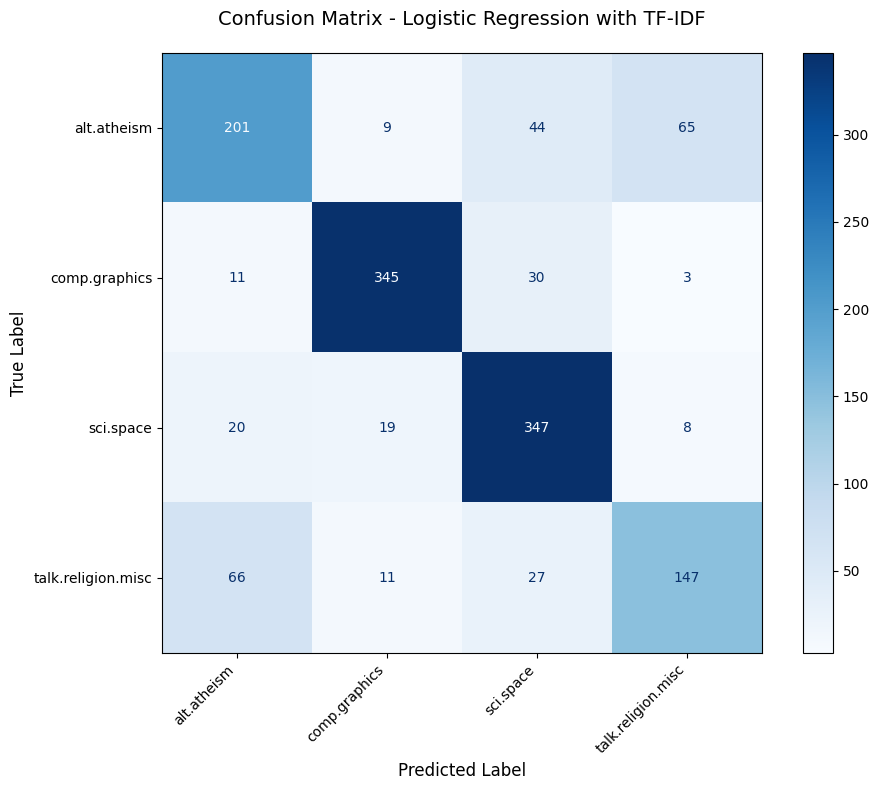

In [21]:
# Step 5.2: Confusion Matrix

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(test_data.target, y_pred_tfidf)
disp = ConfusionMatrixDisplay(
 confusion_matrix=cm,
 display_labels=test_data.target_names
)
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True)
ax.set_title('Confusion Matrix - Logistic Regression with TF-IDF',
fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [22]:
# Step 5.3: Model Comparison Summary

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(f"{'Model':<40} {'Accuracy':>10}")
print("-"*60)
print(f"{'Dummy Baseline (Most Frequent)':<40} {dummy_accuracy:>10.4f}")
print(f"{'Bag-of-Words + Logistic Regression':<40} {accuracy_bow:>10.4f}")
print(f"{'TF-IDF + Logistic Regression':<40} {accuracy_tfidf:>10.4f}")
print("="*60)
print(f"{'Improvement (TF-IDF over BoW):':<40} {(accuracy_tfidf -
accuracy_bow)*100:>9.2f}%")
print(f"{'Improvement (TF-IDF over Baseline):':<40} {(accuracy_tfidf -
dummy_accuracy)*100:>9.2f}%")
print("="*60)



MODEL COMPARISON SUMMARY
Model                                      Accuracy
------------------------------------------------------------
Dummy Baseline (Most Frequent)               0.2912
Bag-of-Words + Logistic Regression           0.7273
TF-IDF + Logistic Regression                 0.7687
Improvement (TF-IDF over BoW):                4.14%
Improvement (TF-IDF over Baseline):          47.75%


In [24]:
# Step 5.4: Feature Importance Analysis

# Extract most important features per class
feature_names = tfidf_vectorizer_opt.get_feature_names_out()
coefficients = lr_tfidf.coef_
print("\n=== Top 10 Most Important Features per Class ===\n")
for i, class_name in enumerate(test_data.target_names):
 print(f"\n{class_name.upper()}")
 print("-" * 50)

 # Get coefficients for this class
 class_coef = coefficients[i]

 # Get top 10 positive (most indicative of class)
 top_positive_idx = np.argsort(class_coef)[-10:][::-1]

 for rank, idx in enumerate(top_positive_idx, 1):
    feature = feature_names[idx]
    coef = class_coef[idx]
    print(f"{rank:2d}. {feature:<20} (weight: {coef:>7.4f})")




=== Top 10 Most Important Features per Class ===


ALT.ATHEISM
--------------------------------------------------
 1. atheism              (weight:  3.1671)
 2. religion             (weight:  3.0888)
 3. atheists             (weight:  2.8482)
 4. atheist              (weight:  2.6737)
 5. bobby                (weight:  2.5602)
 6. islam                (weight:  2.4674)
 7. post                 (weight:  2.4100)
 8. motto                (weight:  2.4097)
 9. deletion             (weight:  2.3223)
10. islamic              (weight:  2.1948)

COMP.GRAPHICS
--------------------------------------------------
 1. graphics             (weight:  5.1556)
 2. image                (weight:  3.4379)
 3. file                 (weight:  3.3577)
 4. computer             (weight:  2.9997)
 5. 3d                   (weight:  2.8336)
 6. hi                   (weight:  2.8206)
 7. looking              (weight:  2.5854)
 8. 68070                (weight:  2.5572)
 9. 42                   (weight:  2.2624)
10

In [25]:
# Step 5.5: Explain Individual Predictions

def explain_prediction(doc_index, vectorizer, model, data, top_n=5):
 """
 Explain prediction for a single document.

 Parameters:
 - doc_index: Index of document in data
 - vectorizer: Fitted TfidfVectorizer
 - model: Trained classifier
 - data: Dataset (train_data or test_data)
 - top_n: Number of top contributing features to show
 """
 # Get document and true label
 doc = data.data[doc_index]
 true_label = data.target_names[data.target[doc_index]]

 # Vectorize and predict
 doc_vector = vectorizer.transform([doc])
 prediction = model.predict(doc_vector)[0]
 predicted_label = data.target_names[prediction]
 probabilities = model.predict_proba(doc_vector)[0]

 print("\n" + "="*70)
 print(f"PREDICTION EXPLANATION - Document #{doc_index}")
 print("="*70)
 print(f"True Label: {true_label}")
 print(f"Predicted Label: {predicted_label}")
 print(f"Correct: {'✓ YES' if prediction == data.target[doc_index] else '✗ NO'}")

 print(f"\n{'Class Probabilities:'}")
 print("-"*70)
 for i, class_name in enumerate(data.target_names): 
   bar = '█' * int(probabilities[i] * 50)
   print(f"{class_name:<25} {probabilities[i]:.4f} {bar}")

 print(f"\nDocument Preview (first 300 chars):")
 print("-"*70)
 print(f"{doc[:300]}...")

 # Get most influential features
 feature_idx = doc_vector.nonzero()[1]
 if len(feature_idx) > 0:
    feature_names_doc = vectorizer.get_feature_names_out() [feature_idx]
    feature_weights = doc_vector.toarray()[0, feature_idx]
    coef_for_class = model.coef_[prediction, feature_idx]
    contribution = feature_weights * coef_for_class

    # Sort by absolute contribution
    top_contrib_idx = np.argsort(np.abs(contribution))[-top_n:][::-1]

    print(f"\nTop {top_n} Contributing Features for'{predicted_label}':")
    print("-"*70)
    for rank, idx in enumerate(top_contrib_idx, 1):
        feature = feature_names_doc[idx]
        contrib = contribution[idx]
        print(f"{rank}. {feature:<25} (contribution: {contrib:>8.4f})")

    print("="*70)
# Explain a few test examples
print("\n### PREDICTION EXPLANATIONS ###")
# Example 1: Correct prediction
explain_prediction(0, tfidf_vectorizer_opt, lr_tfidf, test_data)
# Example 2: Another example
explain_prediction(10, tfidf_vectorizer_opt, lr_tfidf, test_data)


### PREDICTION EXPLANATIONS ###

PREDICTION EXPLANATION - Document #0
True Label: sci.space
Predicted Label: sci.space
Correct: ✓ YES

Class Probabilities:
----------------------------------------------------------------------
alt.atheism               0.0915 ████
comp.graphics             0.1042 █████
sci.space                 0.7348 ████████████████████████████████████
talk.religion.misc        0.0694 ███

Document Preview (first 300 chars):
----------------------------------------------------------------------
TRry the SKywatch project in  Arizona....

Top 5 Contributing Features for'sci.space':
----------------------------------------------------------------------
1. project                   (contribution:   0.9674)
2. arizona                   (contribution:   0.4241)

PREDICTION EXPLANATION - Document #10
True Label: comp.graphics
Predicted Label: comp.graphics
Correct: ✓ YES

Class Probabilities:
----------------------------------------------------------------------
alt.atheis

In [27]:
# Part 6: Hyperparameter Tuning
# Step 6.1: Grid Search with Pipeline

# Create pipeline
pipeline = Pipeline([
 ('tfidf', TfidfVectorizer(
    stop_words='english',
    smooth_idf=True,
    sublinear_tf=True
 )),
 ('clf', LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    n_jobs=-1,
    random_state=42
 ))
])

# Define parameter grid
param_grid = {
 'tfidf__ngram_range': [(1, 1), (1, 2)],
 'tfidf__max_df': [0.7, 0.9],
 'tfidf__min_df': [3, 5],
 'tfidf__max_features': [3000, 5000],
 'clf__C': [0.5, 1.0, 5.0, 10.0]
}
print("\n=== Hyperparameter Tuning with GridSearchCV ===")
print(f"Parameter grid: {len(param_grid['tfidf__ngram_range']) *
len(param_grid['tfidf__max_df']) * len(param_grid['tfidf__min_df']) *
len(param_grid['tfidf__max_features']) * len(param_grid['clf__C'])}combinations")

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
 pipeline,
 param_grid,
 cv=3,
 scoring='accuracy',
 n_jobs=-1,
 verbose=2
)

# Fit (this may take a few minutes)
print("\nTraining... (this may take 2-3 minutes)")
grid_search.fit(train_data.data, train_data.target)
print("\n=== Grid Search Results ===")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Best Parameters:")

for param, value in grid_search.best_params_.items():
 print(f" {param}: {value}")

# Evaluate on test set
y_pred_best = grid_search.predict(test_data.data)
accuracy_best = accuracy_score(test_data.target, y_pred_best)
print(f"\nTest Accuracy (Best Model): {accuracy_best:.4f}")
print(f"Improvement over default: {(accuracy_best - accuracy_tfidf) *100:.2f}%")





=== Hyperparameter Tuning with GridSearchCV ===
Parameter grid: 64combinations

Training... (this may take 2-3 minutes)
Fitting 3 folds for each of 64 candidates, totalling 192 fits

=== Grid Search Results ===
Best CV Score: 0.8201
Best Parameters:
 clf__C: 10.0
 tfidf__max_df: 0.7
 tfidf__max_features: 5000
 tfidf__min_df: 3
 tfidf__ngram_range: (1, 2)

Test Accuracy (Best Model): 0.7701
Improvement over default: 0.15%


In [28]:
# Step 6.2: Cross-Validation Scores Analysis

# Analyze CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
# Show top 10 configurations
print("\n=== Top 10 Configurations ===")
top_configs = cv_results.nsmallest(10, 'rank_test_score')[
 ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]
print(top_configs.to_string(index=False))


=== Top 10 Configurations ===
                                                                                                               params  mean_test_score  std_test_score  rank_test_score
{'clf__C': 10.0, 'tfidf__max_df': 0.7, 'tfidf__max_features': 5000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}         0.820059        0.010289                1
{'clf__C': 10.0, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}         0.820059        0.010289                1
{'clf__C': 10.0, 'tfidf__max_df': 0.7, 'tfidf__max_features': 5000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}         0.817601        0.006180                3
{'clf__C': 10.0, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}         0.817601        0.006180                3
 {'clf__C': 5.0, 'tfidf__max_df': 0.7, 'tfidf__max_features': 5000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}         0.8

In [31]:
# Step 6.3: Error Analysis

# Find misclassified examples
mis_idx = np.where(y_pred_tfidf != test_data.target)[0]
print(f"\n=== Error Analysis ===")
print(f"Number of misclassified examples: {len(mis_idx)} / {len(test_data.target)}")
print(f"Error rate: {len(mis_idx) / len(test_data.target) * 100:.2f}%")

# Analyze confusion between specific classes
print("\n=== Most Common Confusions ===")
cm = confusion_matrix(test_data.target, y_pred_tfidf)

for i in range(len(test_data.target_names)):
     for j in range(len(test_data.target_names)):
        if i != j and cm[i, j] > 10:
            true_class = test_data.target_names[i]
            pred_class = test_data.target_names[j]
            count = cm[i, j]
            print(f"{true_class:<25} → {pred_class:<25} : {count:>3} errors")

# Show a few misclassified examples
print("\n=== Sample Misclassifications ===")
for idx in mis_idx[:3]:
 true_label = test_data.target_names[test_data.target[idx]]
 pred_label = test_data.target_names[y_pred_tfidf[idx]]
 print(f"\nTrue: {true_label} | Predicted: {pred_label}")
 print(f"Text: {test_data.data[idx][:300]}...")
 print("-" * 70)



=== Error Analysis ===
Number of misclassified examples: 313 / 1353
Error rate: 23.13%

=== Most Common Confusions ===
alt.atheism               → sci.space                 :  44 errors
alt.atheism               → talk.religion.misc        :  65 errors
comp.graphics             → alt.atheism               :  11 errors
comp.graphics             → sci.space                 :  30 errors
sci.space                 → alt.atheism               :  20 errors
sci.space                 → comp.graphics             :  19 errors
talk.religion.misc        → alt.atheism               :  66 errors
talk.religion.misc        → comp.graphics             :  11 errors
talk.religion.misc        → sci.space                 :  27 errors

=== Sample Misclassifications ===

True: alt.atheism | Predicted: talk.religion.misc
Text: 



Sure, a person could have great respect for Jesus and yet be an 
atheist.  (Having great respect for Jesus does not necessarily mean 
that one has to follow the Christian [or Muslim